In [ ]:
! pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
! pip install lightfm

In [ ]:
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar6/evaluation.py -O evaluation.py
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar4/dataprep.py -O dataprep.py
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar4/evaluation.py -O evaluation_knn.py

In [ ]:
from collections import defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, vstack
from pprint import pprint

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.datasets import fetch_stackexchange
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from polara.evaluation.pipelines import random_grid
from polara.recommender.data import RecommenderData
from polara.lib.earlystopping import early_stopping_callback
from polara.tools.display import print_frames
from polara.preprocessing.dataframes import matrix_from_observations

from lfm import build_lfm_model, encode_virus_features

from dataprep import leave_last_out, transform_indices, reindex_data, verify_time_split, generate_interactions_matrix, to_numeric_id
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

# 1. Загрузка данных

In [ ]:
review_data = pd.read_csv('drive/MyDrive/recsys_data/reviews.csv').sort_values('user_id')
review_data.head(2)

,uid,user_id,anime_id,text,score,scores,link
96828,210287,-----noname-----,18441,Giant cliffhanger at the end of the season. Th...,2,"{'Overall': '2', 'Story': '1', 'Animation': '6...",https://myanimelist.net/reviews.php?id=210287
14062,221727,-----noname-----,2025,I did not like this anime and I ended up dropp...,4,"{'Overall': '4', 'Story': '6', 'Animation': '3...",https://myanimelist.net/reviews.php?id=221727


In [ ]:
anime_data = pd.read_csv('drive/MyDrive/recsys_data/animes.csv')
anime_data.head(2)

,anime_id,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,1,Cowboy Bebop,"In the year 2071, humanity has colonized sever...","Action, Adventure, Comedy, Drama, Sci-Fi, Space","Apr 3, 1998 to Apr 24, 1999",26,930311,39,26.0,8.81,https://cdn.myanimelist.net/images/anime/4/196...,https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"Another day, another bounty—such is the life o...","Action, Drama, Mystery, Sci-Fi, Space","Sep 1, 2001",1,223199,475,149.0,8.40,https://cdn.myanimelist.net/images/anime/1439/...,https://myanimelist.net/anime/5/Cowboy_Bebop__...


In [ ]:
profile_data = pd.read_csv('drive/MyDrive/recsys_data/profiles.csv').sort_values('user_id')
profile_data.head(2)

,user_id,gender,birthday,favorites_anime,link
9140,-----noname-----,NaN,"Dec 31, 2019","[21, 245, 1575, 2001, 6774, 11061, 16592]",https://myanimelist.net/profile/-----noname-----
16956,---SnowFlake---,NaN,NaN,"[2904, 6773, 10790]",https://myanimelist.net/profile/---SnowFlake---


## 1.2 Анализ данных

In [ ]:
if set(review_data.user_id.values) == set(profile_data.user_id.values):
    print("Обо всех пользователях есть информация в review")

Обо всех пользователях есть информация в review


<Axes: >

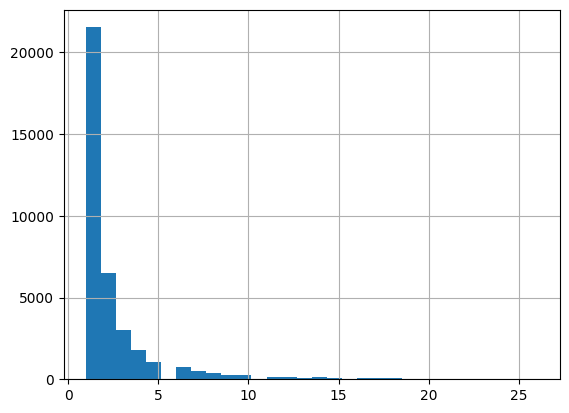

In [ ]:
data = review_data.groupby('user_id', as_index=False).\
    agg(num_anime=('anime_id', len), high_scores=('score', lambda x: sum(np.array(list(x)) > 6)))[['user_id', 'num_anime', 'high_scores']]
data[data.num_anime < np.quantile(data.num_anime, 0.99)].num_anime.hist(bins=30)

# 2. Разделение на train и test

In [ ]:
def split_random(data, userid):
    holdout = data.sample(frac=1.).sort_values('score').drop_duplicates(
        subset=[userid], keep='last'
    )
    remaining = data.drop(holdout.index)
    return remaining, holdout

In [ ]:
test_users = data[(data.num_anime > 10) & (data.high_scores > 1)].sample(500)['user_id'].values

training_ = review_data[~review_data.user_id.isin(test_users)]
testing_ = review_data[review_data.user_id.isin(test_users)]

In [ ]:
data_description = dict(
    users = 'user_id',
    items = 'anime_id',
    feedback = 'score',
    n_users = training_.user_id.nunique(),
    n_items = review_data.anime_id.nunique(),
)
data_description

{'users': 'user_id',
 'items': 'anime_id',
 'feedback': 'score',
 'n_users': 36958,
 'n_items': 7636}

In [ ]:
data_description_test = dict(
    users = 'user_id',
    items = 'anime_id',
    feedback = 'score',
    n_users = testing_.user_id.nunique(),
    n_items = review_data.anime_id.nunique(),
)
data_description_test

{'users': 'user_id',
 'items': 'anime_id',
 'feedback': 'score',
 'n_users': 500,
 'n_items': 7636}

In [ ]:
testset_, holdout_ = split_random(testing_, 'user_id')
holdout_ = holdout_.sort_values('user_id')
testset_ = testset_.sort_values('user_id')

In [ ]:
_, full_data_index = transform_indices(review_data, 'user_id', 'anime_id')
training = reindex_data(training_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')

holdout = reindex_data(holdout_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')
testset = reindex_data(testset_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')

## 2.1 Создание матрицы интеракций

In [ ]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Convert pandas dataframe with interactions into a sparse matrix.
    Allows reindexing user ids, which help ensure data consistency
    at the scoring stage (assumes user ids are sorted in scoring array).
    '''
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values # type your code here
    if rebase_users:
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values # type your code here
    feedback = data[data_description['feedback']].values # type your code here
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))

In [ ]:
train_matrix = generate_interactions_matrix(training, data_description, rebase_users=True)
train_matrix

<36958x7636 sparse matrix of type '<class 'numpy.int64'>'
	with 96267 stored elements in Compressed Sparse Row format>

In [ ]:
test_matrix = generate_interactions_matrix(testset, data_description_test, rebase_users=True)
test_matrix

<500x7636 sparse matrix of type '<class 'numpy.int64'>'
	with 12530 stored elements in Compressed Sparse Row format>

# 3. Создание user features

In [ ]:
def get_age(birthday: str) -> int:
    try:
        date_object = datetime.strptime(birthday, '%b %d, %Y')
        age = (datetime.now() - date_object).days // 365
    except:
        age = None
    return age

def get_user_features(data: pd.DataFrame):
    data = data.copy()
    data['age'] = data.birthday.apply(get_age)
    data['age'].fillna(data['age'].median(), inplace=True)

    data.gender = data.gender.apply(lambda x: 'Unknown' if x not in ('Male', 'Female') else x)
    data = pd.get_dummies(data, columns=['gender']).iloc[:, -4:]
    user_features = csr_matrix(data.iloc[:, -4:].values)
    return user_features

In [ ]:
profile_data.head()

,user_id,gender,birthday,favorites_anime,link
9140,-----noname-----,NaN,"Dec 31, 2019","[21, 245, 1575, 2001, 6774, 11061, 16592]",https://myanimelist.net/profile/-----noname-----
16956,---SnowFlake---,NaN,NaN,"[2904, 6773, 10790]",https://myanimelist.net/profile/---SnowFlake---
5220,--Mizu--,Female,"Jul 3, 1995","[21, 177, 4081, 5678, 6864, 23289]",https://myanimelist.net/profile/--Mizu--
3998,--Sunclaudius,Male,NaN,"[6594, 13125, 34561]",https://myanimelist.net/profile/--Sunclaudius
2379,--animeislife--,Female,"Jul 19, 1996","[249, 2167, 8460, 9989, 10793, 13601, 14467, 1...",https://myanimelist.net/profile/--animeislife--


In [ ]:
train_profile_data = profile_data[~profile_data.user_id.isin(test_users)]
test_profile_data = profile_data[profile_data.user_id.isin(test_users)]

In [ ]:
train_user_features = get_user_features(train_profile_data)
test_user_features = get_user_features(test_profile_data)
test_user_features

<500x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

# 4. Build model

In [ ]:
data_description['user_features'] = train_user_features
data_description['item_features'] = None
data_description

{'users': 'user_id',
 'items': 'anime_id',
 'feedback': 'score',
 'n_users': 36958,
 'n_items': 7636,
 'user_features': <36958x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 73916 stored elements in Compressed Sparse Row format>,
 'item_features': None}

In [ ]:
data_description_test['user_features'] = test_user_features
data_description_test['item_features'] = None
data_description_test

{'users': 'user_id',
 'items': 'anime_id',
 'feedback': 'score',
 'n_users': 500,
 'n_items': 7636,
 'user_features': <500x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in Compressed Sparse Row format>,
 'item_features': None}

## 4.1 Train_model

In [ ]:
lfm_config = dict(
    no_components = 100,
    loss = 'warp',
    max_sampled = 1,
    max_epochs = 100,
    learning_schedule = 'adagrad',
    user_alpha = 1e-3,
    item_alpha = 1e-3,
    random_state = 7032023
)

lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
user_biases, user_embeddings = lfm_model.get_user_representations(features=train_user_features)
item_biases, item_embeddings  = lfm_model.get_item_representations()
user_embeddings.shape, item_embeddings.shape

((36958, 20), (7636, 20))

In [ ]:
full_user_features = vstack([train_user_features, test_user_features])
full_user_features

<37458x4 sparse matrix of type '<class 'numpy.float64'>'
	with 74916 stored elements in Compressed Sparse Row format>

# 5. Predictions

In [ ]:
def lightfm_scoring(model, data, data_description, item_bias=True):
    """
    A standard scoring function adopted for use with LightFM in the user cold-start settings.
    """
    dtype = 'i4'
    test_users = data_description['test_users'].astype(dtype)
    all_items = np.arange(data_description['n_items']).astype(dtype)
    item_index, user_index = np.meshgrid(all_items, test_users, copy=False)

    item_biases = model.item_biases.copy()

    if item_bias:
        model.item_biases *= 0
    lfm_scores = model.predict(
        user_index.ravel(),
        item_index.ravel(),
        user_features = data_description['user_features'],
        item_features = data_description['item_features'],
    )
    model.item_biases[:] = item_biases
    scores = lfm_scores.reshape(len(test_users), len(all_items))
    return scores

def coldstart_evaluate(recommended, holdout, data_description, topn=20):
    """
    Evaluates the performance of a recommender system for item cold-start scenario.
    It takes in `recommended_users` - a 2D array of recommended users for each cold item in the holdout.
    It returns a dictionary containing with evaluation metrics.
    """
    holdout_items = holdout[data_description['items']].values
    assert recommended.shape[0] == len(holdout_items)

    hits_mask = recommended[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_items = recommended.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_items
    cov = len(np.unique(recommended.ravel())) / data_description['n_items']
    ndcg = np.sum(1 / np.log2(1+hit_rank)) / n_test_items
    return {'hr': hr, 'mrr': mrr, 'cov': cov, 'ndcg': ndcg}

## 5.1 Cold case
Матрица интеракций пустая, только признаки пользоватей

In [ ]:
scoring_description = dict(
    test_users = np.arange(data_description['n_users'], review_data.user_id.nunique()),
    user_features = vstack([train_user_features, test_user_features]),
    item_features = None,
    n_items = data_description['n_items']
)

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
downvote_seen_items(lfm_scores, testset, data_description_test)
lfm_scores.shape

(500, 7636)

In [ ]:
topn = 50
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
metrics

{'hr': 0.244,
 'mrr': 0.03371535393707014,
 'cov': 0.023048716605552647,
 'ndcg': 0.07481463692088518}

## 5.2 Warm case all data

In [ ]:
lfm_model.fit_partial(
    interactions=vstack([train_matrix, test_matrix]),
    user_features=full_user_features,
    epochs=10
)

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
downvote_seen_items(lfm_scores, testset, data_description_test)
lfm_scores.shape

(500, 7636)

In [ ]:
topn = 50
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
warm_metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
warm_metrics

{'hr': 0.248,
 'mrr': 0.04165419033135172,
 'cov': 0.02435830277632268,
 'ndcg': 0.0824202969252737}

## 5.3 Intermediate case
Оценка влияния известного количества интеракций на качество рекомендаций

In [ ]:
def sampling_interactions(data: pd.DataFrame, num_interactions: int) -> pd.DataFrame:
    """
    Для каждого пользователя семлируется заданное число интеракций и возвращается
    новый dataframe
    """
    return testset.groupby('user_id').sample(num_interactions)

In [ ]:
result_metrics = defaultdict(list)
topn = 30
for num in tqdm(range(10)):
    for i in range(20):
        lfm_model = build_lfm_model(
            lfm_config,
            train_matrix,
            data_description
        )
        current_testset = sampling_interactions(testset, num)
        current_matrix = generate_interactions_matrix(
            current_testset, data_description_test, rebase_users=True
        )
        current_matrix = vstack([train_matrix, current_matrix])
        lfm_model.fit_partial(
            interactions=current_matrix,
            user_features=full_user_features,
            epochs=10
        )
        lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
        downvote_seen_items(lfm_scores, testset, data_description_test)
        lfm_recs = topn_recommendations(lfm_scores, topn=topn)

        metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
        result_metrics[num].append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for num in tqdm(range(10))

In [ ]:
hr = []
for key in result_metrics:
    temp = []
    for exp in result_metrics[key]:
        temp.append(exp['ndcg'])
    hr.append(temp)
hr = np.array(hr)

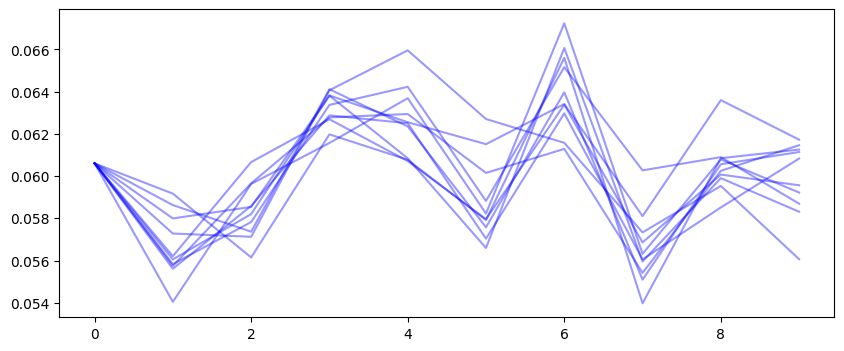

In [ ]:
plt.figure(figsize=(10, 4))
for cur in hr.T:
    plt.plot(cur, color='b',alpha=0.4)

In [ ]:
result_metrics[3]

[{'hr': 0.17,
  'mrr': 0.0245799078976509,
  'cov': 0.012572027239392353,
  'ndcg': 0.05489208489830989},
 {'hr': 0.168,
  'mrr': 0.024541848307290004,
  'cov': 0.01283394447354636,
  'ndcg': 0.05458712220049444},
 {'hr': 0.176,
  'mrr': 0.025612365381239087,
  'cov': 0.012441068622315348,
  'ndcg': 0.05663089459021553},
 {'hr': 0.172,
  'mrr': 0.025344536263208057,
  'cov': 0.012310110005238345,
  'ndcg': 0.05574035803966875},
 {'hr': 0.176,
  'mrr': 0.027620534367371646,
  'cov': 0.012310110005238345,
  'ndcg': 0.05826229451285376},
 {'hr': 0.166,
  'mrr': 0.022150034571677833,
  'cov': 0.01217915138816134,
  'ndcg': 0.05210459338974794},
 {'hr': 0.168,
  'mrr': 0.02564356100247258,
  'cov': 0.012441068622315348,
  'ndcg': 0.05527863089998448},
 {'hr': 0.178,
  'mrr': 0.0273019498511996,
  'cov': 0.012702985856469355,
  'ndcg': 0.058379341525105974},
 {'hr': 0.168,
  'mrr': 0.02600318840106564,
  'cov': 0.01283394447354636,
  'ndcg': 0.055545278465530444},
 {'hr': 0.17,
  'mrr': 0.02

In [ ]:
plt.plot()

# 6. Metrics

In [ ]:
downvote_seen_items(lfm_scores, testset_[testset_.rating > 3.5], data_description_test)

In [ ]:
testset

,uid,user_id,anime_id,text,score,scores,link
23639,257108,-HippySnob-,6627,Half Decays when most of us just sitting here ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=257108
77667,314247,-HippySnob-,7540,"Later On : \r\n""Distinguishing the full analog...",5,"{'Overall': '5', 'Story': '4', 'Animation': '5...",https://myanimelist.net/reviews.php?id=314247
11867,255858,-HippySnob-,4791,Considering the fact that it's way more refres...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=255858
92348,274301,-HippySnob-,5570,Sex & Violence with Machspeed One-Shot Review ...,9,"{'Overall': '9', 'Story': '10', 'Animation': '...",https://myanimelist.net/reviews.php?id=274301
100054,266419,-HippySnob-,6649,A bizarre world building ended a tragic and ep...,3,"{'Overall': '3', 'Story': '1', 'Animation': '1...",https://myanimelist.net/reviews.php?id=266419
...,...,...,...,...,...,...,...
56455,243523,zombie_pegasus,6477,It may seem silly to judge a 30 second commerc...,5,"{'Overall': '5', 'Story': '4', 'Animation': '6...",https://myanimelist.net/reviews.php?id=243523
3151,230191,zombie_pegasus,5240,Keep in mind that this was a failed Youtube re...,6,"{'Overall': '6', 'Story': '5', 'Animation': '8...",https://myanimelist.net/reviews.php?id=230191
85188,256848,zombie_pegasus,5724,"Stop motion is animation too, but this certain...",1,"{'Overall': '1', 'Story': '0', 'Animation': '0...",https://myanimelist.net/reviews.php?id=256848
31228,228873,zombie_pegasus,6143,With all of the praise this movie has gotten i...,7,"{'Overall': '7', 'Story': '7', 'Animation': '1...",https://myanimelist.net/reviews.php?id=228873


In [ ]:
x = np.linspace(0, 10, 100)
curves = [np.sin(x) + np.random.normal(0, 0.1, len(x)) for _ in range(15)]

In [ ]:
plt.fill_betweenx(x, curves[0], curves[2])

NameError: ignored

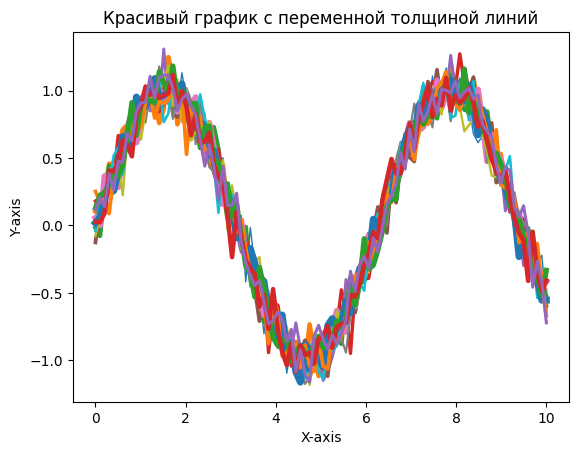

In [ ]:
# Пример данных: создаем некоторые кривые для примера
x = np.linspace(0, 10, 100)
curves = [np.sin(x) + np.random.normal(0, 0.1, len(x)) for _ in range(15)]

# Вычисление плотности для каждой кривой
# Как пример метрики плотности, будем считать среднее евклидово расстояния до соседних кривых
def calculate_density(curves):
    densities = []
    for i, curve in enumerate(curves):
        nearest_curve_distances = []
        for j, other_curve in enumerate(curves):
            if i != j:
                distance = np.mean(np.abs(curve - other_curve))
                nearest_curve_distances.append(distance)
        density = 1 / np.mean(nearest_curve_distances)  # Больше значение, если кривая близко к другим
        densities.append(density)
    return densities

densities = calculate_density(curves)
min_density, max_density = min(densities), max(densities)
normalized_densities = [(density - min_density) / (max_density - min_density) for density in densities]

# Рисуем кривые, регулируя толщину линии в зависимости от плотности
for curve, density in zip(curves, normalized_densities):
    plt.plot(x, curve, linewidth=1 + 4 * density)  # Определяем толщину линии базовая толщина + коэффициент плотности

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Красивый график с переменной толщиной линий')
plt.show()